# Predict Age of Abalone - VotingRegressor

Original Abalone Dataset: https://archive.ics.uci.edu/dataset/1/


| Name           | Alias                | Data Type  | Measurement Unit | Description                 |
|----------------|----------------------|------------|------------------|-----------------------------|
| Sex            | --                   | nominal    | --               | M, F, and I (infant)        |
| Length         | Shell Length         | continuous | mm               | Longest shell measurement   |
| Diameter       | Shell Diameter       | continuous | mm               | perpendicular to length     |
| Height         | Shell Height         | continuous | mm               | with meat in shell          |
| Whole weight   | Whole Weight         | continuous | grams            | whole abalone               |
| Whole weight.1 | Shucked Meat Weight  | continuous | grams            | weight of meat              |
| Whole weight.2 | Viscera (Gut) Weight | continuous | grams            | gut weight (after bleeding) |
| Shell weight   | Shell Dry Weight     | continuous | grams            | after being dried           |
| Rings          | Age Rings            | integer    | --               | +1.5 gives the age in years |

# Best Score

- V12 [0.14851](https://www.kaggle.com/code/gdataranger/predict-age-of-abalone-votingregressor?scriptVersionId=174197357)

## References

Internet

- https://github.com/nishitpatel01/predicting-age-of-abalone-using-regression

- CatBoost
    - https://forecastegy.com/posts/catboost-hyperparameter-tuning-guide-with-optuna/

- XGBoost
    - https://forecastegy.com/posts/xgboost-hyperparameter-tuning-with-optuna/
    - https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663
    - https://practicaldatascience.co.uk/machine-learning/how-to-tune-an-xgbregressor-model-with-optuna

- Optuna
    - https://optuna.readthedocs.io/en/stable/reference/study.html
    - https://stackoverflow.com/questions/67504503/optuna-pass-dictionary-of-parameters-from-outside    
    - https://towardsdatascience.com/state-of-the-art-machine-learning-hyperparameter-optimization-with-optuna-a315d8564de1


Kaggle

- https://www.kaggle.com/code/nazimcherpanov/0-1475-regression-magic-with-voting
- https://www.kaggle.com/code/darkdevil18/0-14736-regression-with-voting-no-feature-eng
- https://www.kaggle.com/code/darkdevil18/0-14727-abalone-no-feature-eng
- https://www.kaggle.com/code/aaachen/ps4e4-xgboost-lightgbm-catboost#XGBoost

# Load Data

In [1]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer


PATH_PREFIX = './kaggle'
if not os.path.exists(f'{PATH_PREFIX}/input'):
    PATH_PREFIX = '/kaggle'
    
FILES = {
    'train': [
        f'{PATH_PREFIX}/input/playground-series-s4e4/train.csv',
        f'{PATH_PREFIX}/input/abalone-dataset/abalone.csv',
    ],
    'test': [
        f'{PATH_PREFIX}/input/playground-series-s4e4/test.csv',
    ],
}

class SexTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        """OneHotEncoding done manually."""
        X['Sex'] = X['Sex'].apply(lambda sex: 2 if sex == 'F' else (1 if sex == 'M' else 0))        
        return X

class AddFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def fix_column_names(self, X):
        """[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
        
        Make column names lowercase and replace spaces with underscores.
        """
        X.columns = [col.lower().replace(' ', '_') for col in X.columns]
        return X
    
    def box_cox(self, X, lmbda=0.5):
        """
        Perform the Box-Cox transformation on the input data.
        """
        if lmbda == 0:
            return np.log(X)
        else:
            return (X ** lmbda - 1) / lmbda

    def transform(self, X, y=None):
        X['Height'] = X['Height'].clip(upper=0.5, lower=0.01)
        #X['height_log'] = np.log(X['Height'])
        X['Volume'] = X['Length'] * X['Diameter'] * X['Height']
        #X['Density'] = X['Whole weight'] / X['Volume'] 
        
        X['width_ratio'] = X['Diameter'] / X['Length']
        X['height_ratio'] = X['Height'] / X['Length']
        X['shell_weight_ratio'] = X['Shell weight'] / X['Whole weight']
        X['mean_weights'] = (X['Whole weight'] + X['Whole weight.1'] + X['Whole weight.2']) / 3
        
        # Box-Cox Transformation
        box_cox_columns = ['Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Volume', 'mean_weights']
        X[box_cox_columns] = X[box_cox_columns].apply(lambda col:self.box_cox(col))
        
        # LightGBM - Warning
        X = self.fix_column_names(X)
        return X

class AbaloneDataset():
    def __init__(self, file='train'):
        self.file = file
        self.data = self.get_data(file)
        if 'rings' in self.data:
            self.data['rings'] = self.data['rings'].astype('float64')
            self.X, self.y = self.data.drop(['rings'], axis=1), self.data['rings']
        else:
            self.X, self.y = self.data, None
        
    def get_data(self, file):
        if file == 'test':
            df = pd.read_csv(FILES[file][0])
            df = df.set_index('id')
        else:
            df1, df2 = pd.read_csv(FILES[file][0]), pd.read_csv(FILES[file][1])
            df1 = df1.drop(['id'], axis=1)
            df2 = df2.rename(columns={'Shucked weight': 'Whole weight.1', 'Viscera weight': 'Whole weight.2'})
            df = pd.concat([df1, df2], axis=0)

        pipe = Pipeline(
            steps=[
                ('sex_transformer', SexTransformer()),
                ('add_features', AddFeatures()),
            ]
        )
        return pipe.fit_transform(df)

    def get_split_datasets(self):
        return train_test_split(self.X, self.y, stratify=self.y, test_size=0.3, random_state=42)

abalone = AbaloneDataset()
abalone.data.head(10)

,sex,length,diameter,height,whole_weight,whole_weight.1,whole_weight.2,shell_weight,rings,volume,width_ratio,height_ratio,shell_weight_ratio,mean_weights
0,2,0.550,0.430,0.150,-0.243299,-0.853702,-1.234494,-1.020204,11.0,-1.623304,0.781818,0.272727,0.311082,-0.710814
1,2,0.630,0.490,0.145,0.126029,-0.646486,-0.948335,-0.868629,11.0,-1.576862,0.777778,0.230159,0.283186,-0.423295
2,0,0.160,0.110,0.025,-1.710172,-1.851676,-1.890455,-1.858579,6.0,-1.958048,0.687500,0.156250,0.238095,-1.801674
3,1,0.595,0.475,0.150,-0.087410,-0.774439,-1.093358,-1.000000,10.0,-1.588205,0.798319,0.252101,0.273373,-0.587909
4,0,0.555,0.425,0.130,-0.231385,-0.784270,-1.200000,-1.111181,9.0,-1.649779,0.765766,0.234234,0.252558,-0.677628
5,2,0.610,0.480,0.170,0.191803,-0.539178,-0.880179,-0.889144,10.0,-1.553789,0.786885,0.278689,0.256869,-0.347527
6,1,0.415,0.325,0.110,-0.848479,-1.186366,-1.465210,-1.278890,9.0,-1.756392,0.783133,0.265060,0.392157,-1.129368
7,2,0.610,0.490,0.150,0.113291,-0.592165,-0.914643,-0.913722,9.0,-1.576514,0.803279,0.245902,0.264219,-0.405635
8,0,0.205,0.150,0.040,-1.571048,-1.759168,-1.795061,-1.800000,4.0,-1.929857,0.731707,0.195122,0.217391,-1.692321
9,0,0.565,0.425,0.125,-0.386309,-0.767929,-1.246342,-1.151472,8.0,-1.653500,0.752212,0.221239,0.276498,-0.749667


In [3]:
abalone.data.describe().T

,count,mean,std,min,25%,50%,75%,max
sex,94792.0,0.930026,0.807263,0.000000,0.000000,1.000000,2.000000,2.000000
length,94792.0,0.517402,0.118308,0.075000,0.445000,0.545000,0.600000,0.815000
diameter,94792.0,0.401952,0.098088,0.055000,0.345000,0.425000,0.470000,0.650000
height,94792.0,0.135618,0.037744,0.010000,0.110000,0.140000,0.160000,0.500000
whole_weight,94792.0,-0.312990,0.563151,-1.910557,-0.704624,-0.211705,0.071232,1.361845
whole_weight.1,94792.0,-0.894007,0.378377,-1.936754,-1.157385,-0.851087,-0.636915,0.439672
whole_weight.2,94792.0,-1.219742,0.266185,-1.955279,-1.411782,-1.185138,-1.034599,-0.256440
shell_weight,94792.0,-1.096111,0.298089,-1.922540,-1.307180,-1.051317,-0.895464,0.004994
rings,94792.0,9.707233,3.178704,1.000000,8.000000,9.000000,11.000000,29.000000
volume,94792.0,-1.656887,0.118241,-1.987155,-1.739538,-1.640313,-1.576155,-1.098862


In [4]:
X, y = abalone.X, abalone.y
X_train, X_validation, y_train, y_validation = abalone.get_split_datasets()

# Correlation Matrix

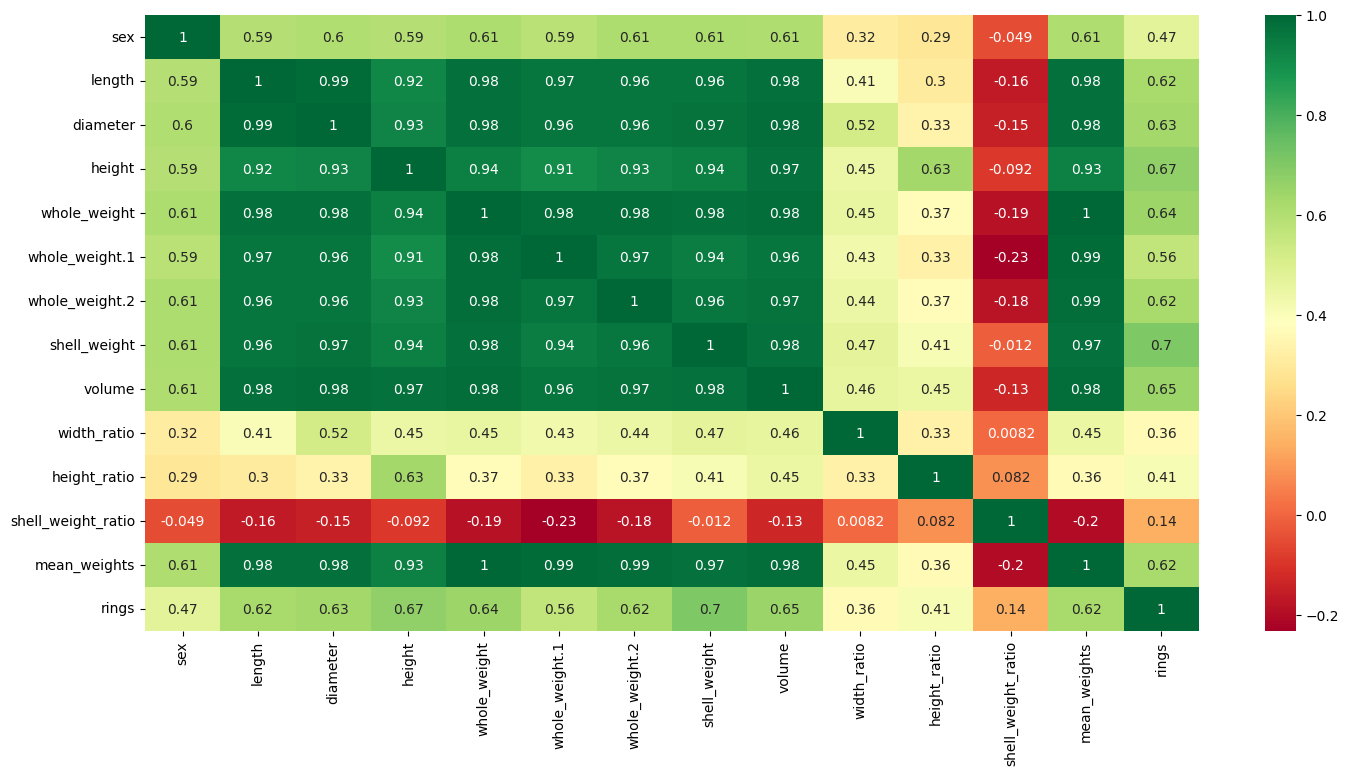

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(17,8))

# Move 'rings' to end for visualization purposes.
abalone.data.insert(len(abalone.data.columns)-1, 'rings', abalone.data.pop('rings'))
sns.heatmap(abalone.data.corr(), annot=True, cmap='RdYlGn')
plt.show()

# Target Distribution

- https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html
- https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html

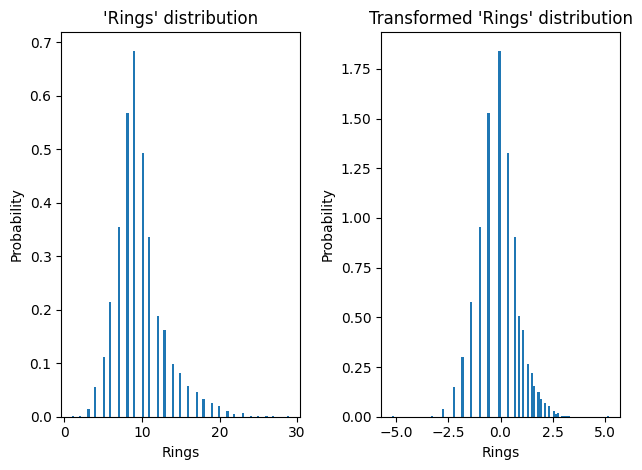

In [6]:
from sklearn.preprocessing import quantile_transform

y_trans = quantile_transform(
    y.to_frame(), n_quantiles=900, output_distribution="normal", copy=True
).squeeze()

f, (ax0, ax1) = plt.subplots(1, 2)

ax0.hist(y, bins=100, density=True)
ax0.set_ylabel("Probability")
ax0.set_xlabel("Rings")
ax0.set_title("'Rings' distribution")

ax1.hist(y_trans, bins=100, density=True)
ax1.set_ylabel("Probability")
ax1.set_xlabel("Rings")
ax1.set_title("Transformed 'Rings' distribution")
plt.tight_layout()

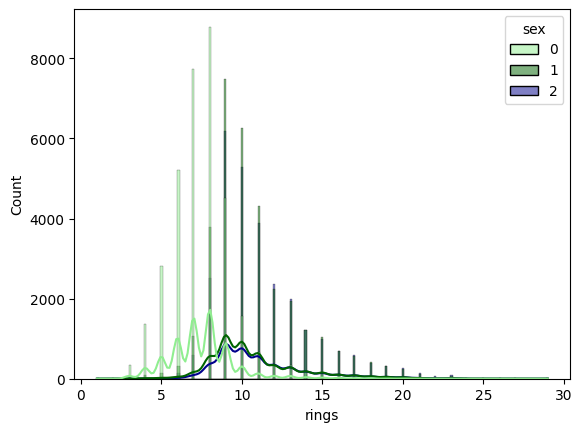

In [7]:
custom_palette = ["lightgreen", "darkgreen", "darkblue"]
sns.histplot(x='rings', data=abalone.data, kde=True, hue='sex', palette=custom_palette)
plt.show()

# Features

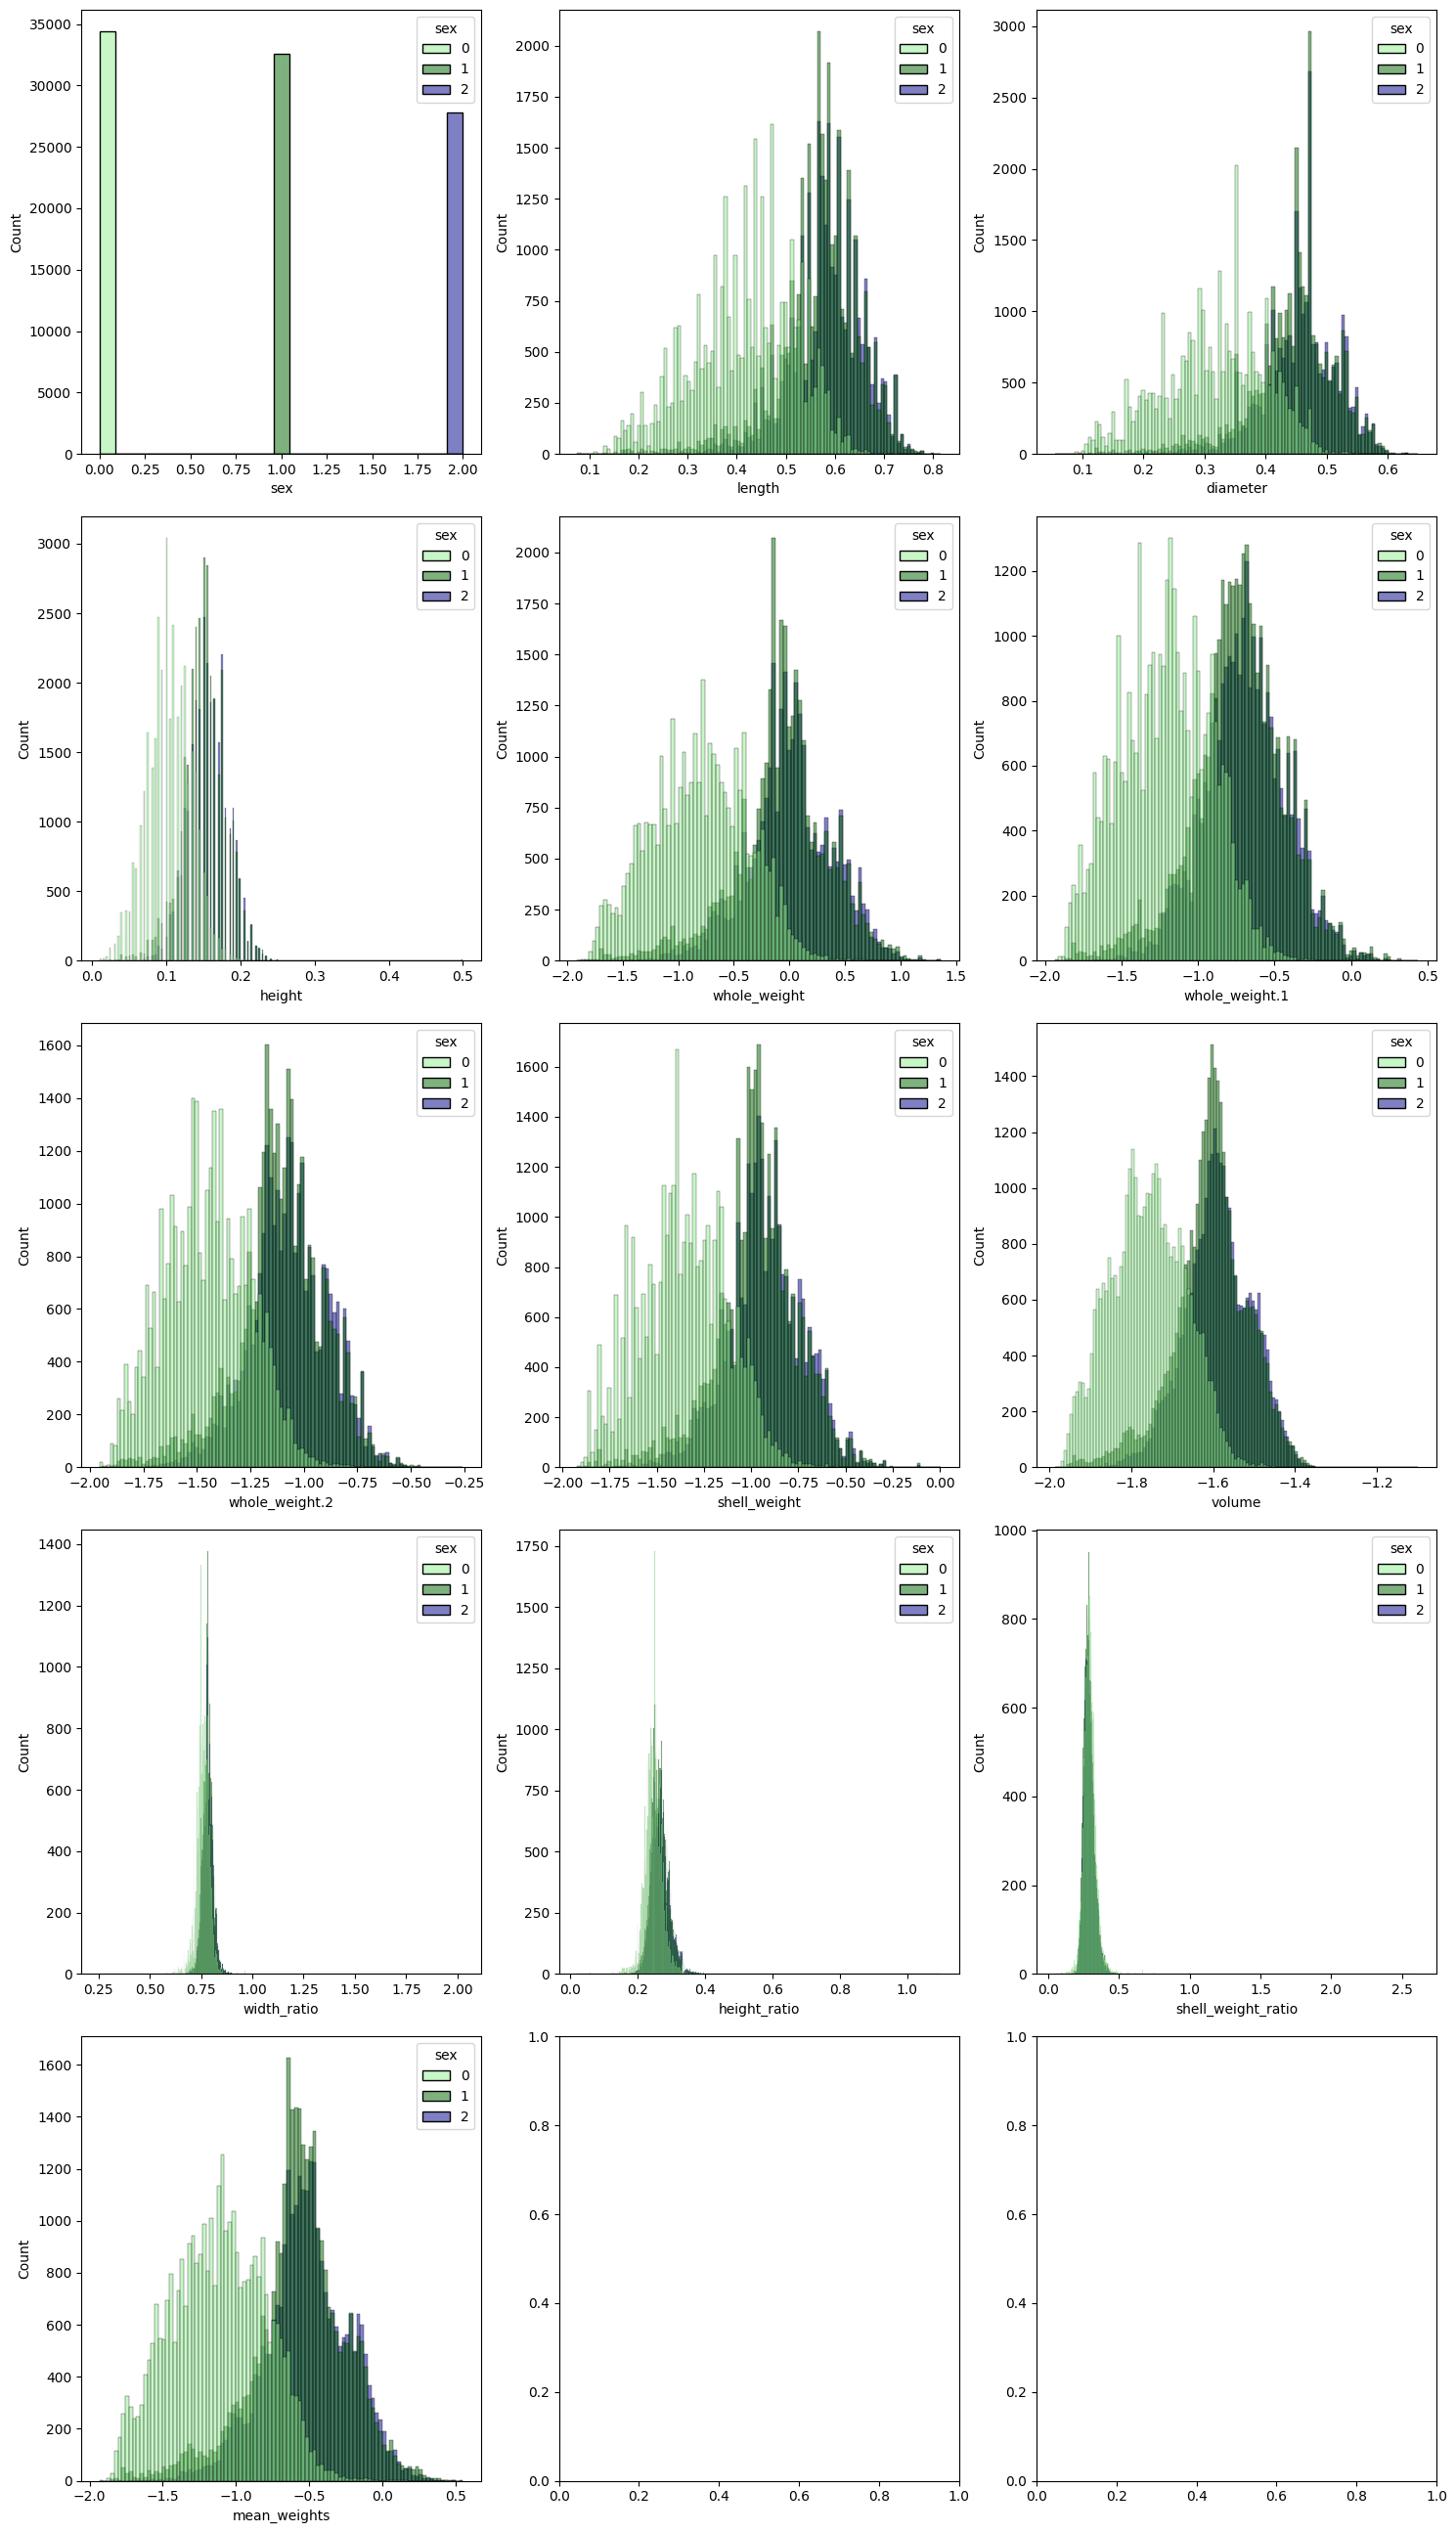

In [8]:
num_features = X.select_dtypes(exclude=object).columns

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, len(num_features)*2))
# Base Features:
#fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, len(num_features)*2))

hue_order = [0, 1, 2] # get blue on top of green

for i, ax in enumerate(axes.flat):
    if i < len(num_features):
        sns.histplot(x=num_features[i], data=X, hue='sex', palette=custom_palette, hue_order=hue_order, ax=ax)
    #ax.set_title(f'{i+1}')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.tight_layout()
plt.show()

# Pair Plot

Pair plot show the bivariate distribution of the varibles i.e. how they behave with each other.

<Figure size 1200x800 with 0 Axes>

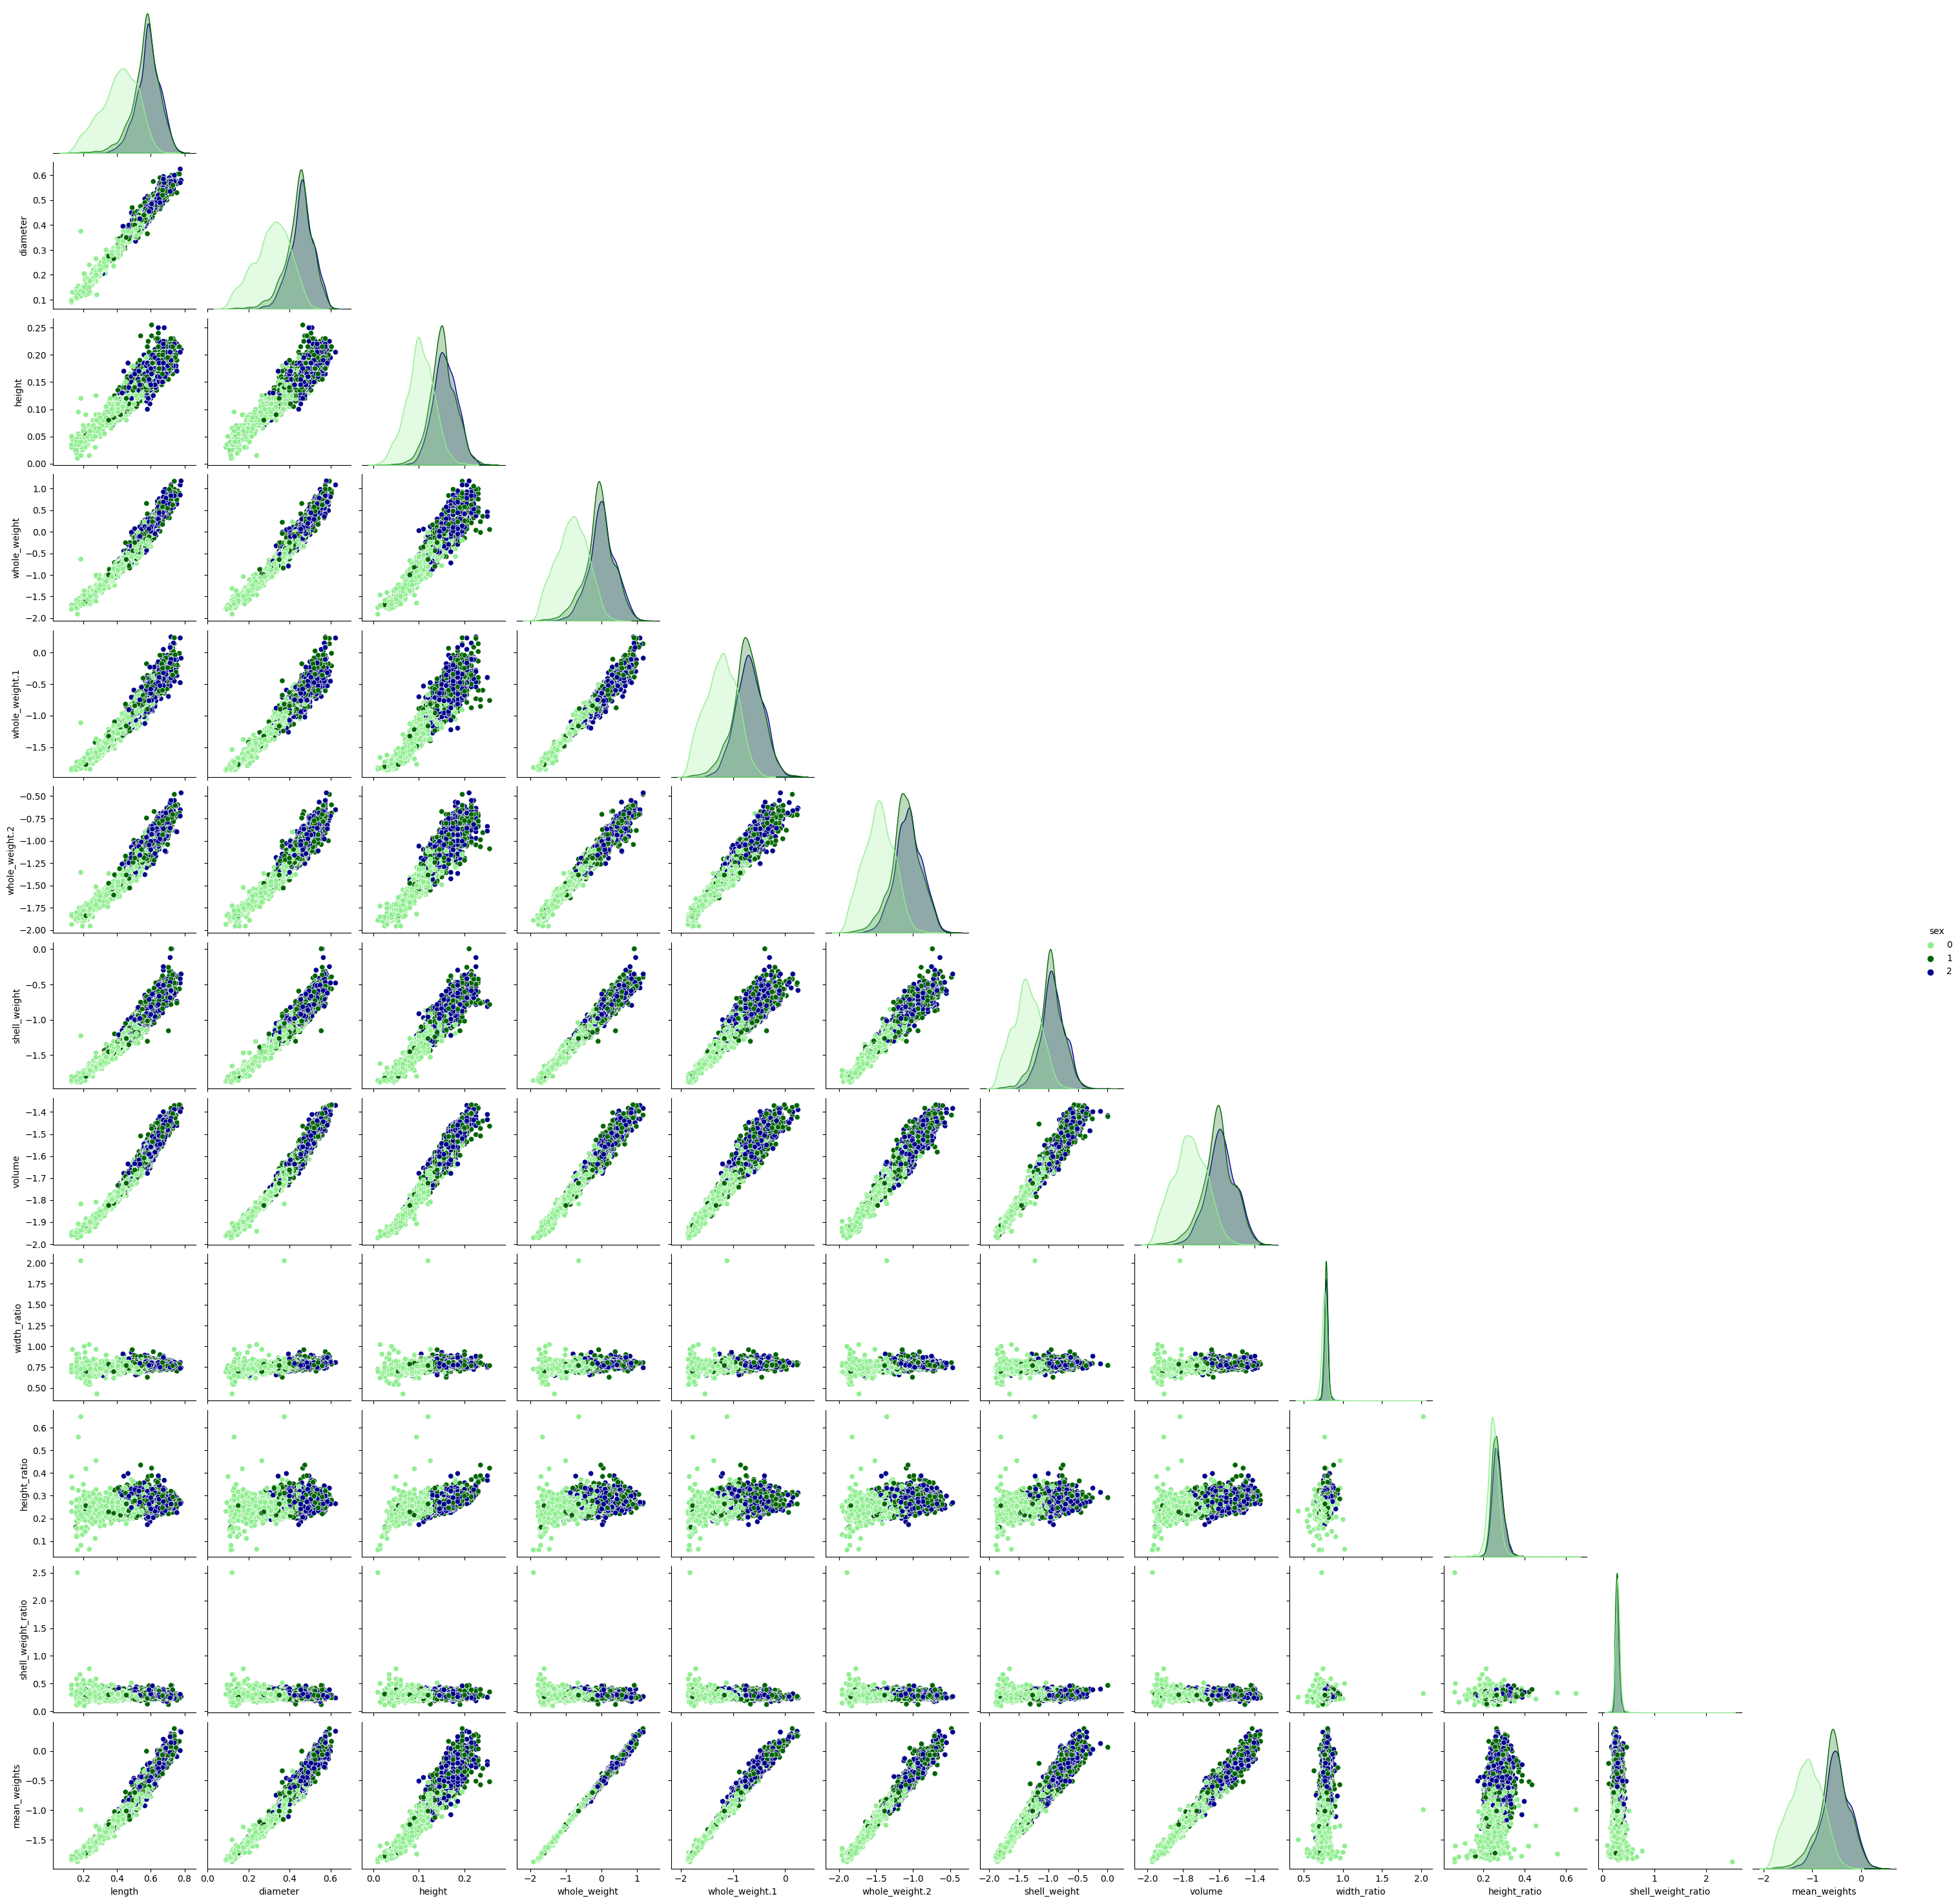

In [9]:
plt.figure(figsize=(12,8))
sns.pairplot(data=X.sample(frac=0.05), hue='sex', palette=custom_palette, corner=True)
plt.show()

# Set Device (GPU)

In [10]:
import torch

def set_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.synchronize()
        print('Info: Device set to CUDA.')
    elif torch.backends.mps.is_available():
        # MPS (Apple's Metal Performance Shaders) on macOS
        device = torch.device('mps')
        torch.mps.synchronize()
        print('Info: Device set to MPS.')
    else:
        device = torch.device('cpu')
        print('Info: Device set to CPU.')
    return device

def get_device_type(device):
    if device.type == 'cpu':
        return 'CPU'
    return 'GPU'

device = set_device()

Info: Device set to CUDA.


# Optimize Model Params

In [11]:
# Other models considered.

if False:
    from sklearn.preprocessing import PolynomialFeatures

    polynomial_features= PolynomialFeatures(degree=2)
    x_poly = polynomial_features.fit_transform(X_train)
    x_poly_validation = polynomial_features.fit_transform(X_validation)
    
    from sklearn.linear_model import LinearRegression
    
    model = LinearRegression()
    model.fit(x_poly, y_train)
    y_pred = model.predict(x_poly_validation)
    rmsle_score(y_validation, y_pred) # degree=2, 0.15557

    from sklearn.svm import SVR

    model = SVR(kernel='rbf')
    model.fit(X_train, y_train)
    y_pred = regressor.predict(X_validation)
    rmsle_score(y_validation, y_pred)

In [12]:
import optuna
from optuna.samplers import TPESampler

optuna.logging.set_verbosity(optuna.logging.WARNING)


class Regressor():
    """
    model = Regressor(model=XGBRegressor, params=best_params['XGB'], device=device).model
    model.fit(...)
    """
    def __init__(self, model, params, device=None, task_type=None):
        if task_type:
            self.regressor=model(task_type=task_type, **params)   
        else:
            self.regressor=model(device=device, **params)
        self.transformer = QuantileTransformer(n_quantiles=900, output_distribution='normal')
        # TODO: I get higher scores using this, even if it seems to apply.
        #self.model = TransformedTargetRegressor(regressor=self.regressor, transformer=self.transformer)
        self.model = self.regressor

base_params = {
    'XGB': {
        'objective': 'reg:squarederror',
        'boosting_type': 'gbtree',
        'tree_method': 'hist', 
        'gamma': 0.0,
        'verbosity': 0,
        'random_state': 42
    },
    'CatBoost': {
        'loss_function': 'RMSE',
        'grow_policy': 'SymmetricTree',
        'verbose': False,
        'cat_features': ['sex'],
        'random_strength': 0,
        'random_state': 42
    },
    'LGBM': {
        #'objective': 'regression',
        #'metric': 'rmse',
        #'importance_type': 'gain',
        'verbosity': -1, #'verbose': -1,
        'random_state': 96
    }
}

def rmsle_score(y_true, y_pred):
    rmsle = mean_squared_log_error(abs(y_true), abs(y_pred), squared=False)
    return rmsle

class Optimizer(object):    
    def __init__(self):
        self.device = set_device()

    def rmsle_score(self, y_true, y_pred):
        rmsle = mean_squared_log_error(abs(y_true), abs(y_pred), squared=False)
        return rmsle

    def objective_xgb(self, trial):
        params = {
            **base_params['XGB'],
            
            'eta': trial.suggest_float('eta', 0.01, 1.0),
            'max_depth': trial.suggest_int('max_depth', 1, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 50),
            'subsample': trial.suggest_float('subsample', 0.05, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
            'lambda': trial.suggest_float('lambda', 1.0, 100.0),
            'n_estimators': trial.suggest_int('n_estimators', 200, 5000)
            #'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        }
        model = Regressor(model=XGBRegressor, params=params, device=self.device).model
        model.fit(X_train, y_train, eval_set=[(X_validation, y_validation)], verbose=False)
        y_pred = model.predict(X_validation)
        return self.rmsle_score(y_validation, y_pred)

    def objective_catboost(self, trial): 
        params = {
            **base_params['CatBoost'],
            
            "n_estimators": trial.suggest_int("n_estimators", 100, 1500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
            'depth': trial.suggest_int('depth', 4, 16),
            # Error: default bootstrap type (bayesian) doesn't support 'subsample' option
            #'subsample': trial.suggest_float('subsample', 0.05, 1.0),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10)
            # colsample_by_level is not supported on GPUs. If it is specified, you will get the following error:
            #"colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0)
        }
        model = Regressor(model=CatBoostRegressor, params=params, task_type=get_device_type(self.device)).model        
        model.fit(X_train, y_train, eval_set=[(X_validation, y_validation)], verbose=False)
        y_pred = model.predict(X_validation)
        return self.rmsle_score(y_validation, y_pred)
    
    def objective_lgbm(self, trial):
        params = {
            **base_params['LGBM'],

            "n_estimators": trial.suggest_int("n_estimators", 400, 1000),
            'num_leaves': trial.suggest_int('num_leaves', 30, 100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 100), 
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
            "lambda_l1": trial.suggest_float("lambda_l1", 0.005, 0.015),
            "lambda_l2": trial.suggest_float("lambda_l2", 0.02, 0.06),
            "max_depth": trial.suggest_int("max_depth", 6, 14),
            "min_split_gain": trial.suggest_float("min_split_gain", 0.1, 1.0)
        }
        model = Regressor(model=LGBMRegressor, params=params, device=get_device_type(self.device)).model
        # Silence! https://datascience.stackexchange.com/a/53992
        model.fit(X_train, y_train, eval_set=[(X_validation, y_validation)]) #verbose_eval=False)
        y_pred = model.predict(X_validation)
        return self.rmsle_score(y_validation, y_pred)

    def objective_vr(self, trial):
        global estimators
        weights = {
            'XGB': trial.suggest_float('XGB', 0.0, 5.0),
            'CatBoost': trial.suggest_float('CatBoost', 0.0, 5.0),
            'LGBM': trial.suggest_float('LGBM', 0.0, 5.0)
        }
        voting_reg = VotingRegressor(estimators, weights=list(weights.values()), verbose=False)
        voting_reg.fit(X_train, y_train)
        y_pred = voting_reg.predict(X_validation)
        return self.rmsle_score(y_validation, y_pred)

    def optimize(self, model, n_trials):
        study = optuna.create_study(direction='minimize',
                                    study_name=f'regression-{model}',
                                    sampler=TPESampler(seed=42))
        match model:
            case 'XGB':
                study.optimize(self.objective_xgb, n_trials=n_trials, show_progress_bar=True)
            case 'CatBoost':
                study.optimize(self.objective_catboost, n_trials=n_trials, show_progress_bar=True)
            case 'LGBM':
                study.optimize(self.objective_lgbm, n_trials=n_trials, show_progress_bar=True)
            case _:
                study.optimize(self.objective_vr, n_trials=n_trials, show_progress_bar=True)
        return study.best_trial

In [13]:
OPTUNED = False
N_TRIALS = 200

if OPTUNED:
    best_params = {}
    
    print('XGB')
    xgb = Optimizer()
    xgb_result = xgb.optimize(model='XGB', n_trials=N_TRIALS)
    best_params['XGB'] = xgb_result.params
    print(best_params['XGB'])

    print('CatBoost')
    catboost = Optimizer()
    catboost_result = catboost.optimize(model='CatBoost', n_trials=N_TRIALS)
    best_params['CatBoost'] = catboost_result.params
    print(best_params['CatBoost'])

    print('LGBM')
    lgbm = Optimizer()
    lgbm_result = lgbm.optimize(model='LGBM', n_trials=N_TRIALS)
    best_params['LGBM'] = lgbm_result.params
    print(best_params['LGBM'])
    
else:
    # Stored best results for scoring.
    best_params = { # 30 optunes
        'XGB': { # 0.151085
            'eta': 0.153544059385273,
            'max_depth': 2,
            'min_child_weight': 21,
            'subsample': 0.5709107954822267,
            'colsample_bytree': 0.6298204530685635,
            'lambda': 27.230092991287002,
            'n_estimators': 3108},
        'CatBoost': { # 0.150531
            'n_estimators': 957,
            'learning_rate': 0.0783519917195005,
            'depth': 7,
            'min_data_in_leaf': 37,
            'l2_leaf_reg': 5.104629857953324},
        'LGBM': { # 0.148906 on 200 optunes
            'n_estimators': 964,
            'num_leaves': 50,
            'learning_rate': 0.03464774206965887,
            'min_child_samples': 20,
            'subsample': 0.8956602385921497,
            'colsample_bytree': 0.4044168833410873,
            'lambda_l1': 0.00535312302939037,
            'lambda_l2': 0.03610628232311737,
            'max_depth': 8,
            'min_split_gain': 0.8632538536968611},
        'VR': { # 0.148931 on 20 optunes
            'XGB': 1.7139964413315811,
            'CatBoost': 0.4163429209043189,
            'LGBM': 4.95902288117729}
    }

best_params

{'XGB': {'eta': 0.153544059385273,
  'max_depth': 2,
  'min_child_weight': 21,
  'subsample': 0.5709107954822267,
  'colsample_bytree': 0.6298204530685635,
  'lambda': 27.230092991287002,
  'n_estimators': 3108},
 'CatBoost': {'n_estimators': 957,
  'learning_rate': 0.0783519917195005,
  'depth': 7,
  'min_data_in_leaf': 37,
  'l2_leaf_reg': 5.104629857953324},
 'LGBM': {'n_estimators': 964,
  'num_leaves': 50,
  'learning_rate': 0.03464774206965887,
  'min_child_samples': 20,
  'subsample': 0.8956602385921497,
  'colsample_bytree': 0.4044168833410873,
  'lambda_l1': 0.00535312302939037,
  'lambda_l2': 0.03610628232311737,
  'max_depth': 8,
  'min_split_gain': 0.8632538536968611},
 'VR': {'XGB': 1.7139964413315811,
  'CatBoost': 0.4163429209043189,
  'LGBM': 4.95902288117729}}

# Optimize Ensemble Weights

In [14]:
model_params = {}
model_params['XGB'] = {**base_params['XGB'], **best_params['XGB']}
model_params['CatBoost'] = {**base_params['CatBoost'], **best_params['CatBoost']}
model_params['LGBM'] = {**base_params['LGBM'], **best_params['LGBM']}
if 'VR' in best_params:
    model_params['VR'] = best_params['VR']

estimators = [
    ('XGB', Regressor(model=XGBRegressor, params=model_params['XGB'], device=device).model),
    ('CatBoost', Regressor(model=CatBoostRegressor, params=model_params['CatBoost'], task_type=get_device_type(device)).model),
    ('LGBM', Regressor(model=LGBMRegressor, params=model_params['LGBM'], device=get_device_type(device)).model)
]
    
if OPTUNED:
    print('VotingRegressor')
    vr = Optimizer()
    vr_result = vr.optimize(model='vr', n_trials=20)
    model_params['VR'] = vr_result.params
    
model_params

{'XGB': {'objective': 'reg:squarederror',
  'boosting_type': 'gbtree',
  'tree_method': 'hist',
  'gamma': 0.0,
  'verbosity': 0,
  'random_state': 42,
  'eta': 0.153544059385273,
  'max_depth': 2,
  'min_child_weight': 21,
  'subsample': 0.5709107954822267,
  'colsample_bytree': 0.6298204530685635,
  'lambda': 27.230092991287002,
  'n_estimators': 3108},
 'CatBoost': {'loss_function': 'RMSE',
  'grow_policy': 'SymmetricTree',
  'verbose': False,
  'cat_features': ['sex'],
  'random_strength': 0,
  'random_state': 42,
  'n_estimators': 957,
  'learning_rate': 0.0783519917195005,
  'depth': 7,
  'min_data_in_leaf': 37,
  'l2_leaf_reg': 5.104629857953324},
 'LGBM': {'verbosity': -1,
  'random_state': 96,
  'n_estimators': 964,
  'num_leaves': 50,
  'learning_rate': 0.03464774206965887,
  'min_child_samples': 20,
  'subsample': 0.8956602385921497,
  'colsample_bytree': 0.4044168833410873,
  'lambda_l1': 0.00535312302939037,
  'lambda_l2': 0.03610628232311737,
  'max_depth': 8,
  'min_spli

# Example Model

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


MODEL: LGBM
RMSLE:  0.14890698252756476


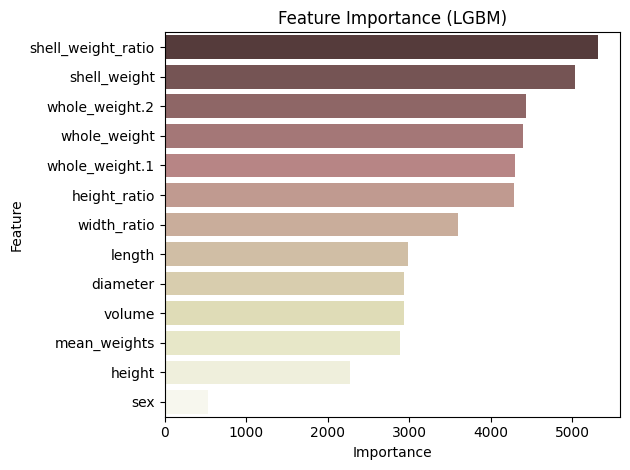

In [15]:
FIT_MODEL = 'LGBM' # 'XGB', 'CatBoost', 'LGBM'

estimators_dict = {}
for name, estimator in estimators:
    estimators_dict[name] = estimator

model = estimators_dict[FIT_MODEL]
model.fit(X_train, y_train)
y_pred = model.predict(X_validation)

print(f'MODEL: {FIT_MODEL}')
print('RMSLE: ', rmsle_score(y_validation, y_pred))

feature_names = X_train.columns
if hasattr(model, 'regressor_'):
    feature_importance = model.regressor_.feature_importances_
else:
    feature_importance = model.feature_importances_

data = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

sns.barplot(x='Importance', y='Feature', data=data.sort_values('Importance', ascending=False),
            palette=sns.color_palette('pink', len(feature_names)))
plt.title(f'Feature Importance ({FIT_MODEL})')
plt.tight_layout()
plt.show()

# Ensemble Model

In [16]:
voting_reg = VotingRegressor(estimators,
                             weights=list(model_params['VR'].values()),
                             n_jobs=-1, verbose=False)
voting_reg.fit(X_train, y_train)
y_pred = voting_reg.predict(X_validation)

print('RMSLE: ', rmsle_score(y_validation, y_pred))

if False:
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    score = cross_val_score(voting_reg, X, y, scoring=make_scorer(rmsle_score), cv=kf)

    print(f'voting score: {score.mean()}')

RMSLE:  0.14893583019008239


# Submission

In [17]:
test = AbaloneDataset(file='test')
submission = test.data

# 90615,10.013862468723856 -> 90615,10
# submission['rings'] = voting_reg.predict(submission).round(0).astype(int)
# TODO: Others with lower scores are not rounding - dropped to 0.14851 V12
submission['rings'] = voting_reg.predict(submission)

# regenerate 'id' from index values
submission['id'] = submission.index

outfile = 'submission.csv'
df = submission[['id', 'rings']]
df.to_csv(outfile, index=False)

!head -10 {outfile}

id,rings
90615,10.012405940477452
90616,9.838488952606506
90617,10.172626790490964
90618,10.656932379316538
90619,7.672807315281436
90620,9.356975729749053
90621,11.293778423543152
90622,6.198827758206832
90623,7.950321652629462


# Appendix

## XGBoost model is set to run on the CUDA device (GPU), but the input data is on the CPU.

```python
X, y = abalone.X, abalone.y

model = XGBRegressor(tree_method='hist', device=device, verbose=False, random_state=42)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

def rmsle_score(y_true, y_pred):
    msle = mean_squared_log_error(abs(y_true), abs(y_pred))
    return np.sqrt(msle)

scores = cross_val_score(model, X, y, scoring=make_scorer(rmsle_score), cv=kf, n_jobs=-1)
scores = np.absolute(scores)
print('Mean RMSLE: %.3f (%.3f)' % (scores.mean(), scores.std()) + f' : {model.__class__.__name__}')
```

> ```
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:52:28] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
> - Use a data structure that matches the device ordinal in the booster.
> - Set the device for booster before call to inplace_predict.
> ```

The warning message you're seeing is related to the device mismatch between the XGBoost model and the input data. Specifically, the XGBoost model is set to run on the CUDA device (GPU), but the input data is on the CPU.

This mismatch can lead to higher memory usage and slower performance, as the model needs to transfer the data from the CPU to the GPU for processing.

The potential solutions mentioned in the warning message are:

1. Use a data structure that matches the device ordinal in the booster: This means that you should ensure that the input data is in a format that can be efficiently transferred to the GPU, such as a NumPy array or a PyTorch tensor